# Bollinger Band Stategy 

In [52]:
# Data manipulation packages
import numpy as np
import pandas as pd

# Financial packages
import talib as ta
import yfinance as yf
import pyfolio as pf

# Graphing packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import datetime
from datetime import date

from talib import MA_Type

## Import dataset

In [53]:
data = yf.download('MSFT')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,242.259995,46135800
2022-06-14,243.860001,245.740005,241.509995,244.490005,244.490005,28651500
2022-06-15,248.309998,255.300003,246.419998,251.759995,251.759995,33111700


## Compute Indicators

In [32]:
# def compute_bollinger_bands(df,window=20,sigma=2):
#     df['sma'] = df['Adj Close'].rolling(window).mean()
#     df['std'] = df['Adj Close'].rolling(window).std()
#     df['BBup'] = df['sma'] + df['std'] * sigma # Calculate top band
#     df['BBdown'] = df['sma'] - df['std'] * sigma # Calculate bottom band
#     return df

In [56]:
def compute_bollinger_bands(df,window):
    df['BBup'], df['BBcenter'], df['BBdown']  = ta.BBANDS(data['Adj Close'], matype=MA_Type.T3,timeperiod=window)
    return df

In [57]:
# data = compute_bollinger_bands(data,20,1.5) #using standard deviations from sma
data = compute_bollinger_bands(data,20) #using Talib 

<AxesSubplot:xlabel='Date'>

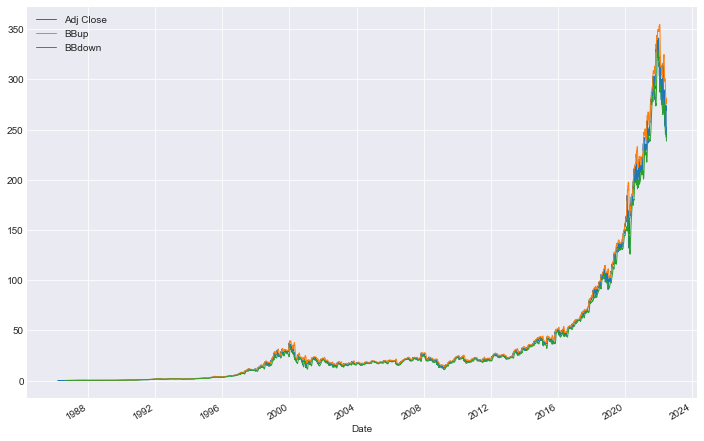

In [58]:
data[['Adj Close', 'BBup', 'BBdown']].plot(grid=True, linewidth=1, figsize=(12, 8))

## Compute Signals

In [59]:
data['signal'] = np.where((data['Adj Close'] < data['BBdown'])  
            & (data['Adj Close'].shift(1) > data['BBdown'].shift(1)), 1, 0)

data['signal'] = np.where((data['Adj Close'] > data['BBup']) 
            & (data['Adj Close'].shift(1) < data['BBup'].shift(1)), -1, data['signal'])

data['signal'] = data['signal'].shift(1)
data.dropna(inplace=True)
data['signal'].value_counts()


 0.0    8279
-1.0     432
 1.0     317
Name: signal, dtype: int64

## Compute Position

In [60]:
data['position'] = data['signal'].replace(to_replace=0, method='ffill')
data['position'].value_counts()

-1.0    5242
 1.0    3755
 0.0      31
Name: position, dtype: int64

## Compute Returns

In [61]:
# Returns
data['returns'] = data['Adj Close'].pct_change()
# Strategy returns 
data['strategy_returns'] = data['returns'].shift(-1) * data['position']
data

,Open,High,Low,Close,Adj Close,Volume,BBup,BBcenter,BBdown,signal,position,returns,strategy_returns
Date,,,,,,,,,,,,,
1986-08-25,0.102431,0.102431,0.100694,0.102431,0.064384,2419200,0.067128,0.062843,0.058557,0.0,0.0,NaN,-0.000000
1986-08-26,0.102431,0.102431,0.101563,0.101563,0.063838,10857600,0.067189,0.062944,0.058698,0.0,0.0,-0.008474,0.000000
1986-08-27,0.101563,0.102431,0.100694,0.101563,0.063838,9532800,0.067276,0.063046,0.058816,0.0,0.0,0.000000,0.000000
1986-08-28,0.101563,0.102431,0.101563,0.101563,0.063838,3427200,0.067324,0.063146,0.058967,0.0,0.0,0.000000,-0.000000
1986-08-29,0.101563,0.102431,0.097222,0.098958,0.062201,25430400,0.067365,0.063234,0.059102,0.0,0.0,-0.025649,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,242.259995,46135800,278.622576,261.365356,244.108137,0.0,1.0,-0.042413,0.009205
2022-06-14,243.860001,245.740005,241.509995,244.490005,244.490005,28651500,280.285195,261.158304,242.031414,1.0,1.0,0.009205,0.029735
2022-06-15,248.309998,255.300003,246.419998,251.759995,251.759995,33111700,280.462183,260.842096,241.222008,0.0,1.0,0.029735,-0.026970


## Extract Entry/Exit Points

In [62]:
data['entry'] = data['position'].diff()
data['entry'].value_counts()

 0.0    8811
 2.0     108
-2.0     107
-1.0       1
Name: entry, dtype: int64

## Strategy Performance Analysis

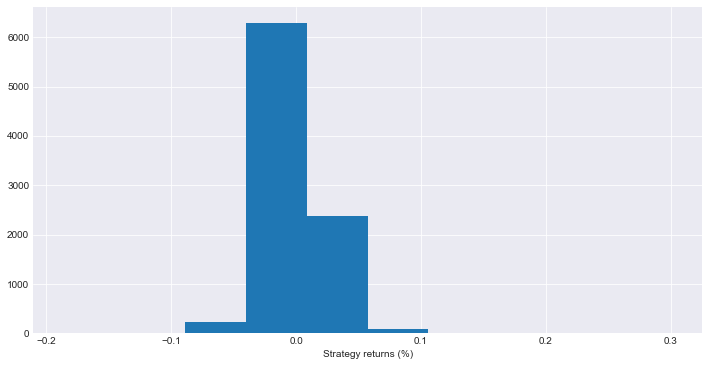

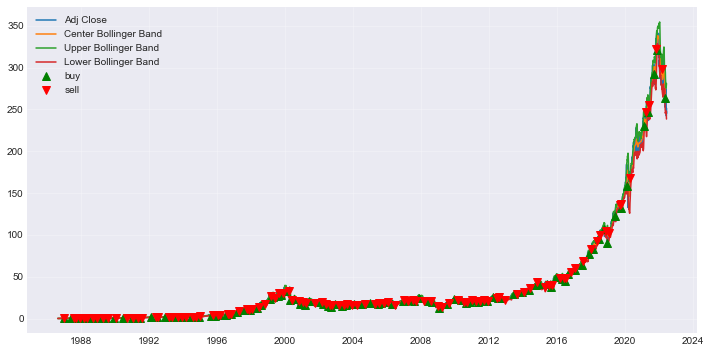

/Users/alfred/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alfred/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


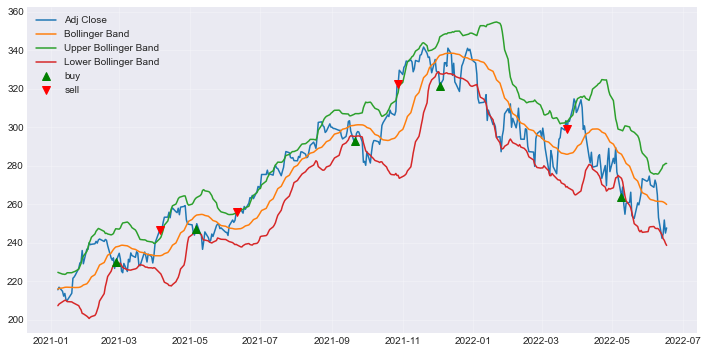

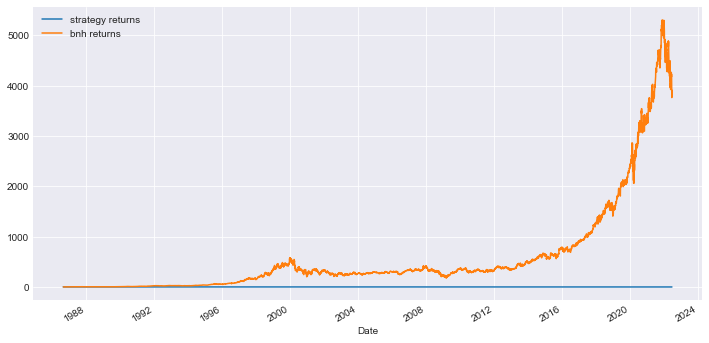

Start date,1986-08-25
End date,2022-06-17
Total months,429
,Backtest
Annual return,-8.9%
Cumulative returns,-96.5%
Annual volatility,33.8%
Sharpe ratio,-0.11
Calmar ratio,-0.09
Stability,0.84
Max drawdown,-96.9%


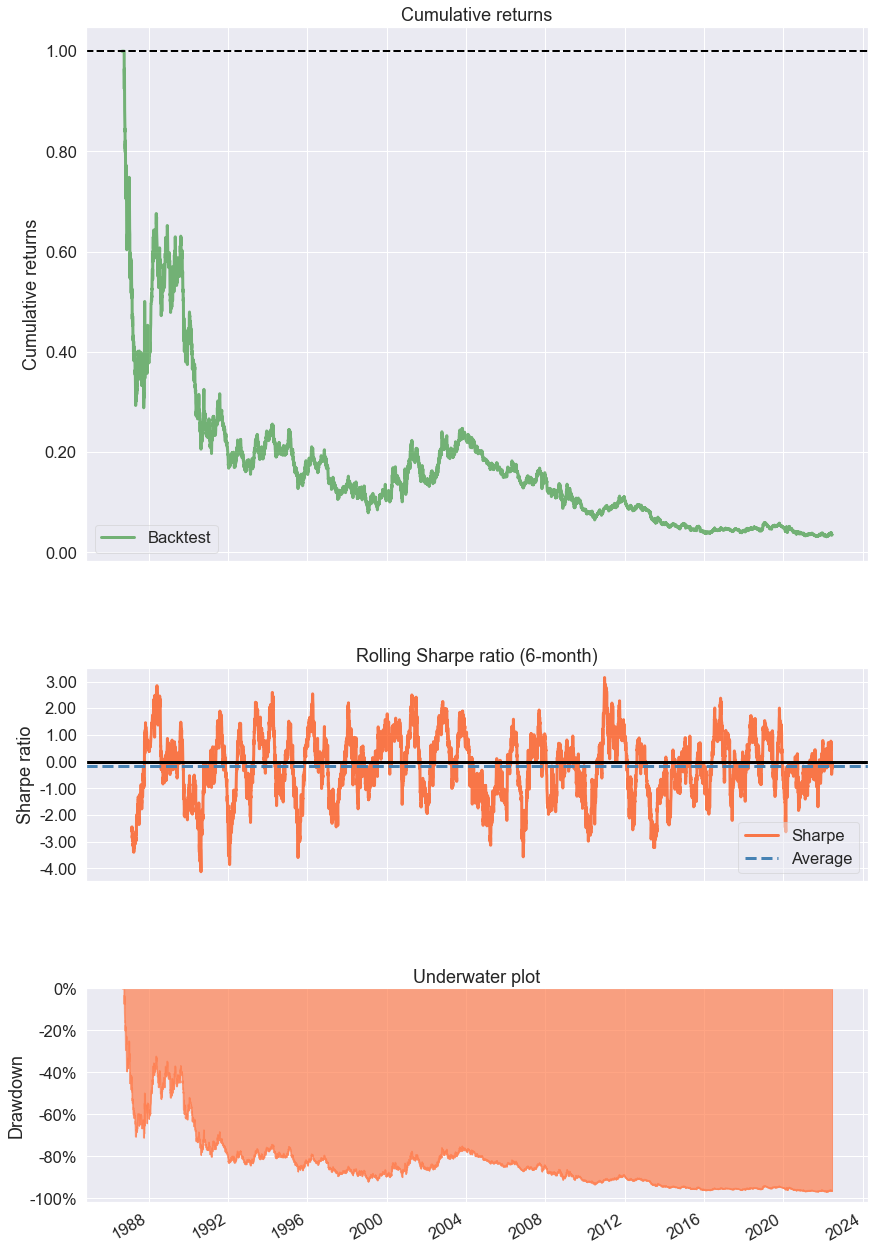

In [63]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12, 6
data.strategy_returns.hist()
plt.xlabel('Strategy returns (%)')
plt.show()

plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data['Adj Close'], label = 'Adj Close')
#plt.plot(data['sma'], label = 'Moving Average')
plt.plot(data['BBcenter'], label = 'Center Bollinger Band')
plt.plot(data['BBup'], label = 'Upper Bollinger Band')
plt.plot(data['BBdown'], label = 'Lower Bollinger Band')
plt.plot(data[data.entry == 2].index, data['Adj Close'][data.entry == 2], '^', color = 'g', markersize = 8,label='buy')
plt.plot(data[data.entry == -2].index, data['Adj Close'][data.entry == -2], 'v',color = 'r', markersize = 8,label='sell')
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data['Adj Close'][-365:], label = 'Adj Close')
#plt.plot(data['sma'][-365:], label = 'Moving Average')
plt.plot(data['BBcenter'][-365:], label = 'Bollinger Band')
plt.plot(data['BBup'][-365:], label = 'Upper Bollinger Band')
plt.plot(data['BBdown'][-365:], label = 'Lower Bollinger Band')
plt.plot(data[-365:][data.entry == 2].index, data['Adj Close'][-365:][data.entry == 2], '^', color = 'g', markersize = 8,label='buy')
plt.plot(data[-365:][data.entry == -2].index, data['Adj Close'][-365:][data.entry == -2], 'v',color = 'r', markersize = 8,label='sell')
plt.legend()
plt.show()

(data.strategy_returns+1).cumprod().plot(label='strategy returns')
(data.returns+1).cumprod().plot(label='bnh returns')
plt.legend()
plt.show()

# general analytics)
pf.create_simple_tear_sheet(data.strategy_returns)